<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/DefectNet/RAAFTingForFunAndProfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAAFTing for Fun And Profit

Notebook prepared by Kevin Stubbs

Contact: kevin.d.stubbs@gmail.com

In this notebook I will demonstrate how to use the radially averaged absolute Fourier transform (RAAFT) feature vectors to automatically detect defects in TEM crystal images. 

The basic observation underlying this technique is that crystal images are invariant under rotation and translation (i.e. if you rotate or translate a crystal it's still the same crystal). By constructing feature vectors which are also invariant under these same actions it is possible to differentiate between the parts of the image which contain a defect and those which do not contain a defect. Since the RAAFT feature vectors are based on relatively simple tools, it is possible to make theoretical guarantees about how good the RAAFT feature vectors are as descriptor of crystal images (arXiv paper forthcoming).

Generally speaking, this method works quite well when the defects are large compared to the lattice spacing but will struggle when the defects are small.

# Import/Install Modules

In [0]:
nbtype = !python -c "import google.colab" 2>/dev/null; echo $?
if not int(nbtype[0]):
    !git clone https://github.com/pycroscopy/AICrystallographer.git
    !cp -r AICrystallographer/DefectNet/* . 

Cloning into 'AICrystallographer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 1634 (delta 17), reused 20 (delta 8), pack-reused 1597
Receiving objects: 100% (1634/1634), 165.74 MiB | 36.73 MiB/s, done.
Resolving deltas: 100% (908/908), done.
Checking out files: 100% (276/276), done.


Imported needed modules

In [0]:
import numpy as np
import ffts
import matplotlib.pyplot as plt

# RAAFT Analysis

Let's begin by loading a test image:

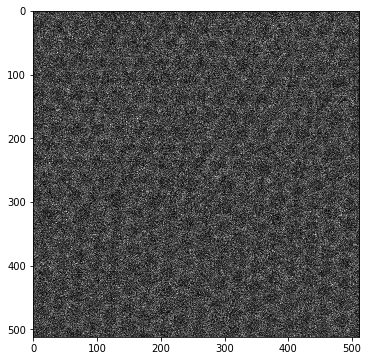

In [0]:
imgdata = np.load('exp_data/G-GrainBoundary-4nm.npy')
imgsrc = imgdata

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(imgsrc, cmap = 'gray');

Radial Averaged Absolute Fourier Transform (RAAFT) analysis works by taking a modified version of the Fourier transform on overlapping patches in the target image. As part of the method you must specify 7 parameters

1. <code>num_clusters</code> (int) - The number of clusters to use when doing the analysis 
2. <code>patch_size</code> (int) - The size of patch to use. Because of problems with rounding this must be an even number.
3. <code>num_patches_x</code>/<code>num_patches_y</code> (int) - The patches in the image will be laid out on an equally spaced grid which is (num_patches_x) by (num_patches_y). A warning is raised if you don't have enough patches to cover the whole image
4. <code>which_norm</code> (float) - Which of the L^p norms should be used to normalize each patch. Generally either 1 or 2 work well
5. <code>inner</code>/<code>outer</code> (float) - To help with noise it is sometimes useful to truncate Fourier transform of each patch. If a patch has dimensions (px, py) then the points (x,y) which are not set to zero must satisfy: inner * sqrt(px^2 + py^2) <= sqrt(x^2 + y^2) <= outer * sqrt(px^2 + py^2)

In [0]:
raaft_parameters = {
    "num_clusters" : 2,
    "patch_size" : 50,
    "num_patches_x" : 100,
    "num_patches_y" : 100,
    "which_norm" : 1,
    "inner": 0,
    "outer": .5
}

mask_img = ffts.raaftRun(raaft_parameters, imgsrc)

Generating feature vectors...done
Clustering...done
Generating masks...done


The <code>mask_img</code> generated from <code>raaftRun()</code> is a (num_clusters) by (image height) by (image width) array with values representing how confident we are each pixel is in each cluster. To get a clearer idea of the different clusters let's make a hard decision for each pixel about which cluster it belongs in:

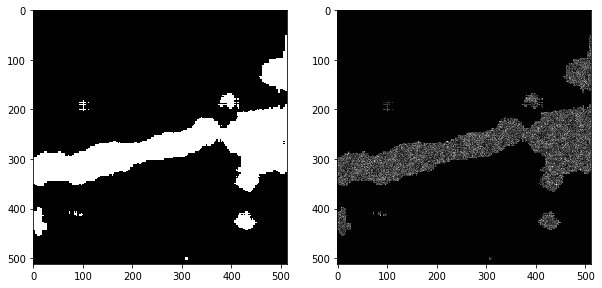

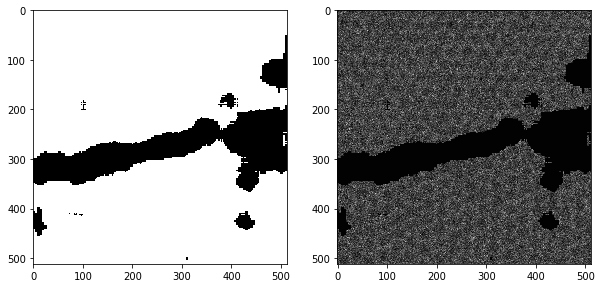

In [0]:
# Performs a hard decision for each pixel in the image
mask_img2 = np.zeros(mask_img.shape)
tmp = np.max(mask_img, axis=0)
for i in range(mask_img.shape[0]):
    mask_img2[i,:,:] = mask_img[i,:,:] == tmp    

# Plots the decisions for each cluster
for idx in range(mask_img.shape[0]):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 20))
    ax[0].imshow(mask_img2[idx,:,:], cmap = 'gray');
    ax[1].imshow(mask_img2[idx,:,:] * imgsrc, cmap = 'gray');